In this example we use AdOR method on `cause-effect` pairs.

# Import Packages

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output

np.set_printoptions(precision=5 , suppress=True)

In [2]:
# import AdOR package
from ador import *

## Data

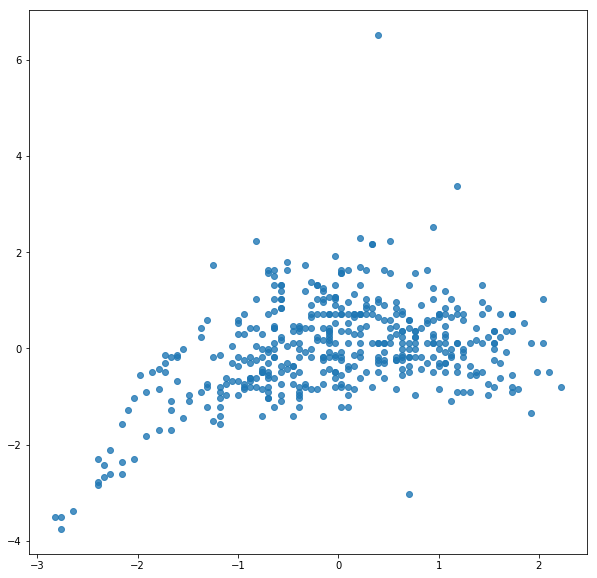

452


In [5]:
DatasetIdx = '0023'

MetaFile = pd.read_csv('pairs\\pairmeta.txt', delim_whitespace=True, encoding='utf-8', header=None,
                       names=['SetIdx','FirstColCause','LastColCause','FirstColEffect','LastColEffect','Weight'])
DataSetMeta = MetaFile.iloc[np.where(MetaFile.SetIdx == np.int32(DatasetIdx))[0][0]]
DataFile = pd.read_csv('pairs\\pair'+DatasetIdx+'.txt', delim_whitespace=True, encoding='utf-8', header=None, dtype=np.float32)

RawX = np.asarray(DataFile.iloc[:,int(DataSetMeta.FirstColCause-1):int(DataSetMeta.LastColCause)])
RawY = np.asarray(DataFile.iloc[:,int(DataSetMeta.FirstColEffect-1):int(DataSetMeta.LastColEffect)])
X = (RawX-np.mean(RawX))/np.std(RawX)
Y = (RawY-np.mean(RawY))/np.std(RawY)

NumSamples = X.shape[0]
dimX = X.shape[1]
dimY = Y.shape[1]

Hx = np.arange(np.min(X),np.max(X),0.01)[np.newaxis].T

plt.figure(figsize=(10,10))
plt.scatter(X, Y, alpha=0.8)
#plt.scatter(Y, X, c='r',alpha=0.5)
plt.show()
print(NumSamples)

In [6]:
BatchSize = 256

In [8]:
STT = 30
print('Y entropy: ',np.mean([kNNEntropy(Y, KOfNN=i) for i in range(STT, STT+5)]))
print('X entropy: ',np.mean([kNNEntropy(X, KOfNN=i) for i in range(STT, STT+5)]))

Y entropy:  1.1937665489614346
X entropy:  1.3223327904611426


# Forward Regression

# Create New Model

In [9]:
# struct new model using ador class
MODEL1 = ador(NumOfRegressors=dimX, BatchSize=BatchSize)

In [10]:
# add dense layers (fully_connected) to regression network.
MODEL1.Reg_GetDenseLayer(LayerID='hidden1', LayerSize=6, Activation=tf.nn.tanh,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='hidden2', LayerSize=6, Activation=tf.nn.sigmoid,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='hidden3', LayerSize=6, Activation=tf.nn.leaky_relu,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer.
MODEL1.Reg_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                        WeightInitializer=tf.contrib.layers.xavier_initializer())

In [11]:
# add dense layers (fully_connected) to mutual information network.
MODEL1.MI_GetDenseLayer(LayerID='hidden1', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.MI_GetDenseLayer(LayerID='hidden2', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.MI_GetDenseLayer(LayerID='hidden3', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer
MODEL1.MI_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                       WeightInitializer=tf.contrib.layers.xavier_initializer())

In [12]:
# when the structure of network is constructed, call 'ConstructGraph' method. it creates the whole computational graph
MODEL1.ConstructGraph()

In [13]:
# specify optimizer for each net
MODEL1.Reg_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)
MODEL1.MI_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)

In [14]:
# you can create tensorboard summary. list of scalers and histograms can be changed by 'Options' input
MODEL1.TensorboardSummaryCreator(directory="summaries\\CE_"+DatasetIdx+"_01")

# Train the Model

In [15]:
# hyper-parameters

# learn rates
RLearnRate = 0.0005
MILearnRate = 0.0005

# number of updating steps at each iteration
nReg_Steps = 20
nMI_Steps = 20

# number of whole iterations
MaxIters = 1000

In [16]:
# starting a new tensorflow session

# configurations
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

# call 'GetSession' method to create a new session
MODEL1.GetSession(config=config)

iteration: 0     Estimated Entropy of Residual:  1.0894605318372683


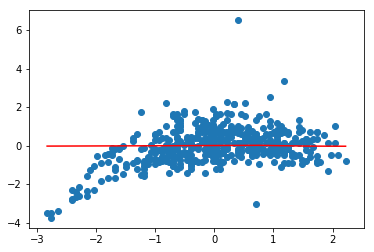

iteration: 50     Estimated Entropy of Residual:  1.0925607847504208


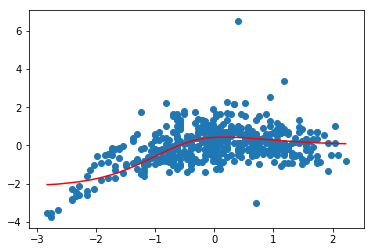

iteration: 100     Estimated Entropy of Residual:  1.0799805117525842


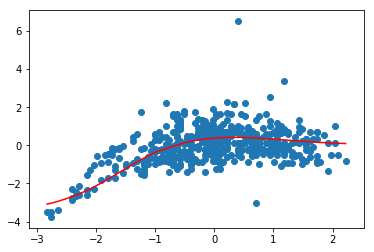

iteration: 150     Estimated Entropy of Residual:  1.0229032542669616


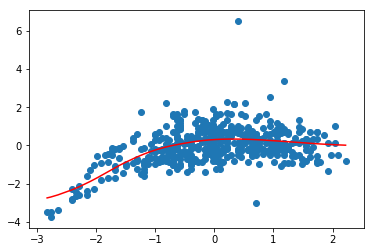

iteration: 200     Estimated Entropy of Residual:  0.9979920189578309


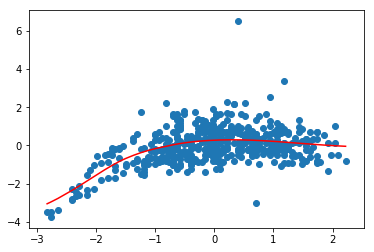

iteration: 250     Estimated Entropy of Residual:  0.9905569557413467


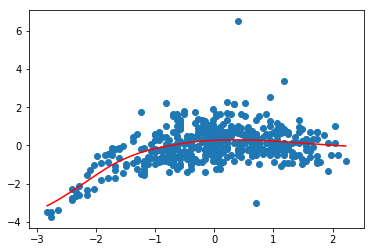

iteration: 300     Estimated Entropy of Residual:  1.0415438962642907


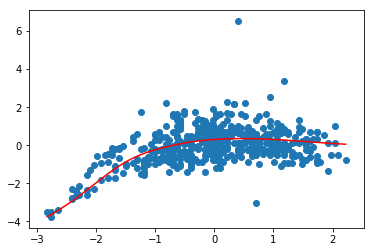

iteration: 350     Estimated Entropy of Residual:  1.025070349874714


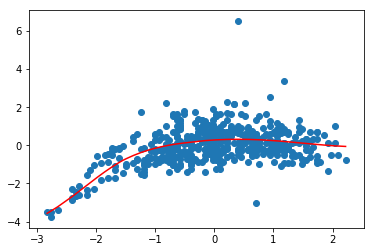

iteration: 400     Estimated Entropy of Residual:  1.043041070177357


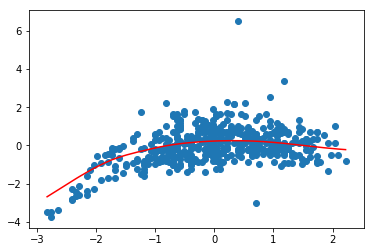

iteration: 450     Estimated Entropy of Residual:  1.0156147081924796


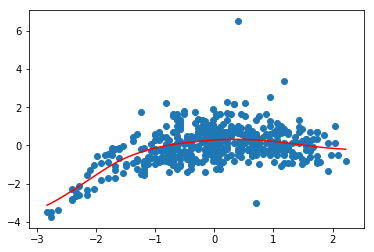

iteration: 500     Estimated Entropy of Residual:  1.0502852289321019


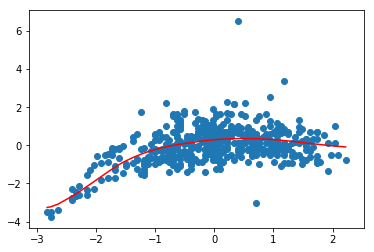

iteration: 550     Estimated Entropy of Residual:  1.0437948899402292


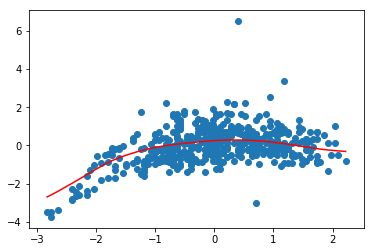

iteration: 600     Estimated Entropy of Residual:  1.0180021408449256


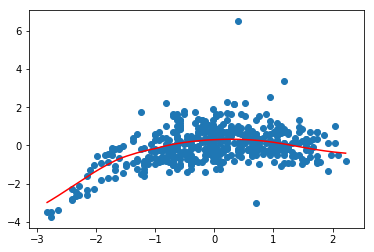

iteration: 650     Estimated Entropy of Residual:  1.017681335443008


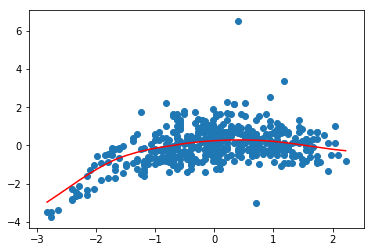

iteration: 700     Estimated Entropy of Residual:  1.028499968684239


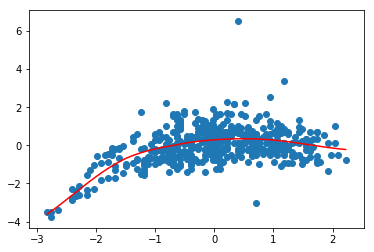

iteration: 750     Estimated Entropy of Residual:  1.0622713780701147


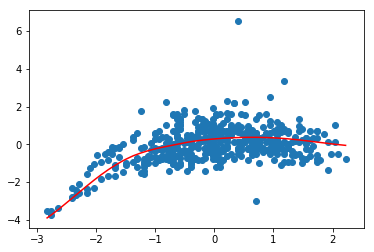

iteration: 800     Estimated Entropy of Residual:  1.086191362094139


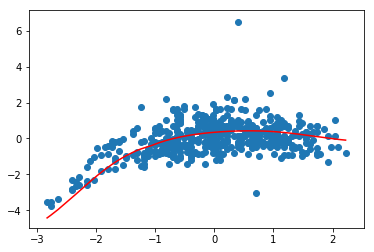

iteration: 850     Estimated Entropy of Residual:  1.1138487379538695


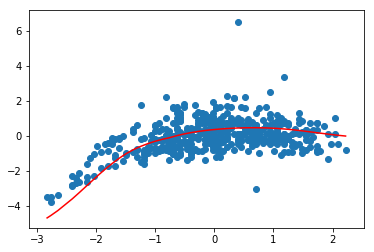

iteration: 900     Estimated Entropy of Residual:  1.07467112356926


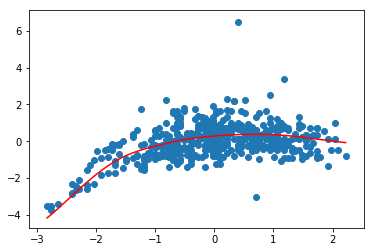

iteration: 950     Estimated Entropy of Residual:  1.0235489243124798


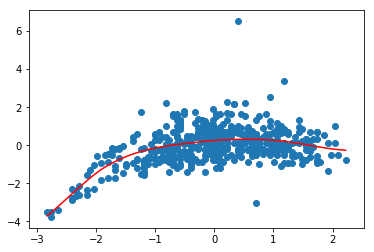

In [17]:
EnsemblePredicts = list()
EnsemblePredictsHx = list()
np_loss_all = list()
Res_Entr_all = list()

# iteration
for iters in range(MaxIters):
    
    # use 'UpdateRegNet' method to update regression network by back-propagattion
    AllPredicts, _, np_loss, _, _, Res_Entr = MODEL1.UpdateRegNet(X=X, Y=Y, iteration=iters, 
                                                            RegLearnRate=RLearnRate, nReg_Steps=nReg_Steps)
    np_loss_all.append(np_loss)
    Res_Entr_all.append(Res_Entr)
    
    # use 'UpdateMINet' method to update mutual-information network by back-propagattion
    _ = MODEL1.UpdateMINet(X=X, Y=Y, iteration=iters, 
                           MILearnRate=MILearnRate, nMI_Steps=nMI_Steps)
    
    # use 'TestModel' method to validate the obtained regression-net
    MSE_iter, _ = MODEL1.TestModel(X=X, Y=Y, iteration=iters)
    
    
    # verbose at each 50 iteration
    if iters%50 == 0:
        print('iteration:', iters , '    Estimated Entropy of Residual: ', Res_Entr)
        
        if iters>=200:
            EnsemblePredicts.append(AllPredicts-np.mean(AllPredicts))
            AllPredictsHx = MODEL1.PredictAfterTrain(X=Hx)
            EnsemblePredictsHx.append(AllPredictsHx-np.mean(AllPredictsHx))
        
        Imlists = sorted(zip(*[X, AllPredicts+np.mean(Y)-np.mean(AllPredicts)]))
        new_x, new_y = list(zip(*Imlists))
        
        plt.figure()
        plt.plot(new_x, new_y, 'r')
        plt.scatter(X, Y)
        plt.show()
    
# use 'PredictAfterTrain' method to get predictions (outputs of regression)
AllPredictsAfterTrain = MODEL1.PredictAfterTrain(X=X)

# ensemble
EnsemblePredictsWhole = np.mean(EnsemblePredicts, axis=0)
Imlists = sorted(zip(*[X, EnsemblePredictsWhole+np.mean(Y)-np.mean(EnsemblePredictsWhole)]))
new_x_AT, new_y_AT = list(zip(*Imlists))

In [18]:
# use 'EndSession' method to close session after training.
# Note that by closing session, the trained model no longer can be used.
MODEL1.EndSession()

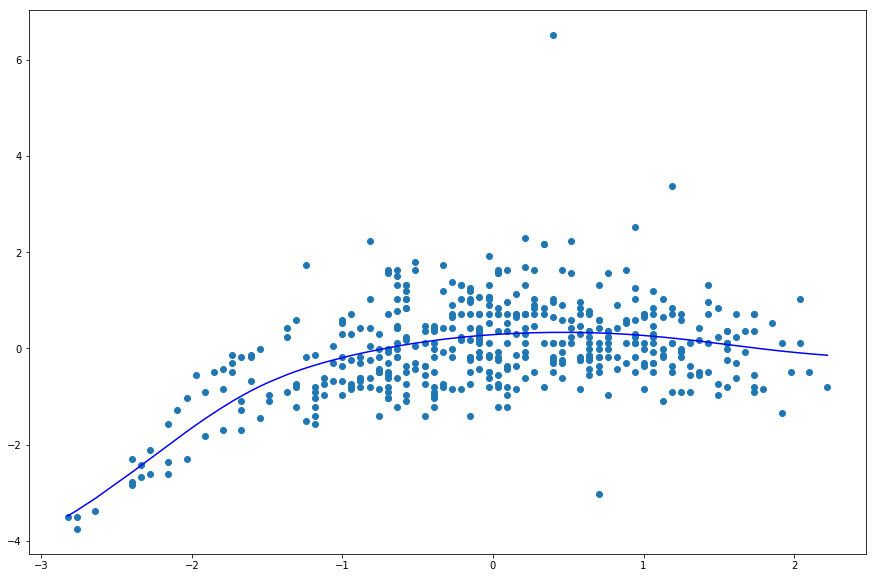

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(X, Y)
plt.plot(new_x_AT, new_y_AT, 'b')
plt.show()

In [20]:
ImlistsMain = sorted(zip(*[X, Y]))
new_x_Main, new_y_Main = list(zip(*ImlistsMain))
new_y_AT = np.asarray(new_y_AT)
InData = np.concatenate([new_x_Main, new_y_Main-new_y_AT], axis=1)
ForwardError = np.asarray(new_y_Main-new_y_AT)
ForwardPredict = np.asarray(new_y_AT)

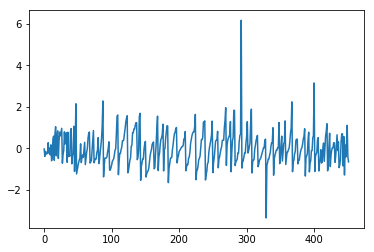

0.8075059529051322


In [21]:
plt.plot(ForwardError)
plt.show()
print(np.std(ForwardError))

In [22]:
tf.reset_default_graph()

InputSize = 2
batch_size = 2*BatchSize//2

layer_ids = ['hidden1','out']#['hidden1','hidden2','hidden3','hidden4','hidden5','out']
layer_sizes = [InputSize, 40, 1]#[InputSize, 5, 10, 10, 5, 2, 1]

# Inputs and Labels
train_inputs = tf.placeholder(tf.float32, shape=[batch_size, layer_sizes[0]], name='train_inputs')


# Learning Rate
tf_learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')


# Weight and Bias definitions
for idx, lid in enumerate(layer_ids):
    #print(idx,'   ',lid)
    with tf.variable_scope(lid):
        w = tf.get_variable('weights',shape=[layer_sizes[idx], layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('bias',shape= [layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())

# Calculating Predictions
h = train_inputs
for lid in layer_ids:
    with tf.variable_scope(lid,reuse=True):
        w, b = tf.get_variable('weights'), tf.get_variable('bias')
        #print(w,'\n\n')
        if lid != 'out':
            h = tf.nn.leaky_relu(tf.matmul(h,w)+b,name=lid+'_output')
        else:
            h = tf.nn.xw_plus_b(h,w,b,name=lid+'_output')


# Calculating Loss
tf_loss = tf.negative(Loss_MI(h), name='loss_MINE')

# Optimizer
optimizer = tf.train.AdamOptimizer(tf_learning_rate, beta1=0.96)
grads_and_vars = optimizer.compute_gradients(tf_loss)
tf_loss_minimize = optimizer.minimize(tf_loss)

In [23]:
n_epochs = 5000
LearningRate = 0.00005

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

session = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

avg_loss = list()
for epoch in range(n_epochs):
    loss_per_epoch = []
    
    JointBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    MarginalBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    for i in range(2*NumSamples//batch_size):
        
        # =================================== Training for one step ========================================
        batch_joint = InData[JointBatchIndeces[:,i],:]    # Get one batch of joint data
        batch_marginal = InData[MarginalBatchIndeces[:,i],:]    # Get one batch of marginal data
        batch_marginal[:,0:dimX] = batch_joint[:,0:dimX]
        AllBatch = np.concatenate([batch_joint, batch_marginal], axis=0)
        l,_ = session.run([tf_loss, tf_loss_minimize],
                          feed_dict={train_inputs: AllBatch,
                                     tf_learning_rate: LearningRate})
        
        loss_per_epoch.append(l)
    if epoch%50==0:
        print('Average loss in epoch %d: %.5f'%(epoch,-np.mean(loss_per_epoch)))    
    avg_loss.append(-np.mean(loss_per_epoch))
    
    

session.close()

Average loss in epoch 0: -0.01722
Average loss in epoch 50: -0.01830
Average loss in epoch 100: -0.00919
Average loss in epoch 150: -0.00363
Average loss in epoch 200: -0.00223
Average loss in epoch 250: -0.00102
Average loss in epoch 300: -0.00159
Average loss in epoch 350: -0.00025
Average loss in epoch 400: 0.00046
Average loss in epoch 450: 0.00009
Average loss in epoch 500: 0.00209
Average loss in epoch 550: 0.00282
Average loss in epoch 600: -0.00124
Average loss in epoch 650: 0.00040
Average loss in epoch 700: 0.00496
Average loss in epoch 750: 0.00349
Average loss in epoch 800: 0.00345
Average loss in epoch 850: 0.00560
Average loss in epoch 900: 0.00361
Average loss in epoch 950: 0.00199
Average loss in epoch 1000: 0.00014
Average loss in epoch 1050: 0.00323
Average loss in epoch 1100: 0.00299
Average loss in epoch 1150: 0.00528
Average loss in epoch 1200: 0.00637
Average loss in epoch 1250: 0.00233
Average loss in epoch 1300: 0.00736
Average loss in epoch 1350: 0.00218
Averag

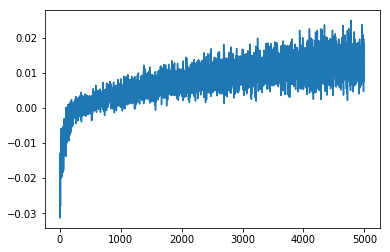

0.012773045


In [24]:
plt.plot(avg_loss)
plt.show()
print(np.mean(avg_loss[-500:-1]))

# Backward Direction

# Create New Model

In [25]:
# struct new model using ador class
MODEL2 = ador(NumOfRegressors=dimY, BatchSize=BatchSize)

In [26]:
# add dense layers (fully_connected) to regression network.
MODEL2.Reg_GetDenseLayer(LayerID='hidden1', LayerSize=6, Activation=tf.nn.tanh,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.Reg_GetDenseLayer(LayerID='hidden2', LayerSize=6, Activation=tf.nn.sigmoid,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.Reg_GetDenseLayer(LayerID='hidden3', LayerSize=6, Activation=tf.nn.leaky_relu,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer.
MODEL2.Reg_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                        WeightInitializer=tf.contrib.layers.xavier_initializer())

In [27]:
# add dense layers (fully_connected) to mutual information network.
MODEL2.MI_GetDenseLayer(LayerID='hidden1', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.MI_GetDenseLayer(LayerID='hidden2', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL2.MI_GetDenseLayer(LayerID='hidden3', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer
MODEL2.MI_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                       WeightInitializer=tf.contrib.layers.xavier_initializer())

In [28]:
# when the structure of network is constructed, call 'ConstructGraph' method. it creates the whole computational graph
MODEL2.ConstructGraph()

In [29]:
# specify optimizer for each net
MODEL2.Reg_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)
MODEL2.MI_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)

In [30]:
# you can create tensorboard summary. list of scalers and histograms can be changed by 'Options' input
MODEL2.TensorboardSummaryCreator(directory="summaries\\CE_"+DatasetIdx+"_Back_01")

# Train the Model

In [31]:
# hyper-parameters

# learn rates
RLearnRate = 0.0005
MILearnRate = 0.0005

# number of updating steps at each iteration
nReg_Steps = 20
nMI_Steps = 20

# number of whole iterations
MaxIters = 1000

In [32]:
# starting a new tensorflow session

# configurations
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

# call 'GetSession' method to create a new session
MODEL2.GetSession(config=config)

iteration: 0     Estimated Entropy of Residual:  1.3601030171284605


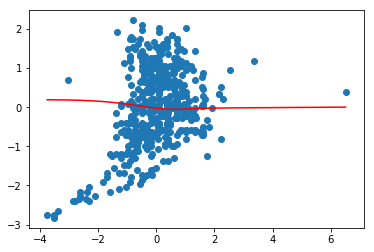

iteration: 50     Estimated Entropy of Residual:  1.21250532348882


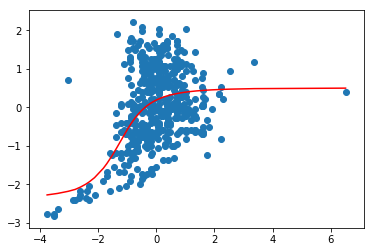

iteration: 100     Estimated Entropy of Residual:  1.186529750606634


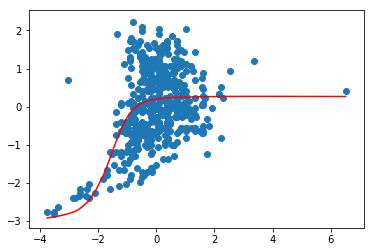

iteration: 150     Estimated Entropy of Residual:  1.1987863860564754


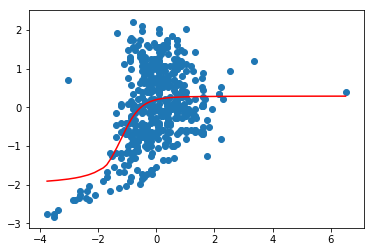

iteration: 200     Estimated Entropy of Residual:  1.1991890868266806


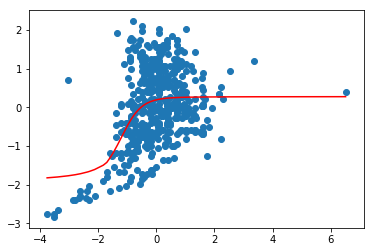

iteration: 250     Estimated Entropy of Residual:  1.1933037651136673


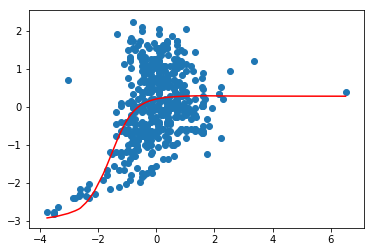

iteration: 300     Estimated Entropy of Residual:  1.2718711028815388


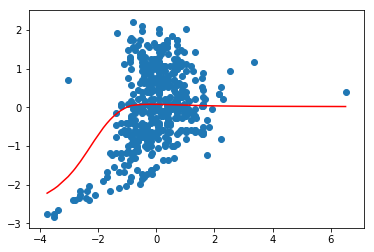

iteration: 350     Estimated Entropy of Residual:  1.1831855043359982


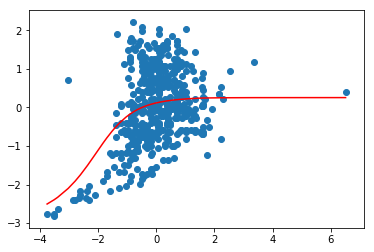

iteration: 400     Estimated Entropy of Residual:  1.2048417951403914


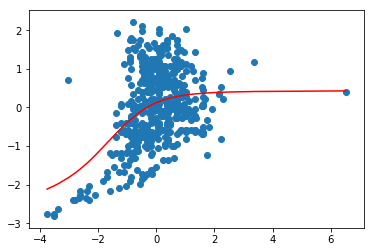

iteration: 450     Estimated Entropy of Residual:  1.195320800048473


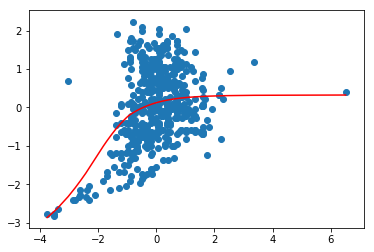

iteration: 500     Estimated Entropy of Residual:  1.2068459842236843


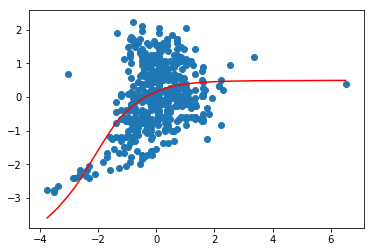

iteration: 550     Estimated Entropy of Residual:  1.2023308427124726


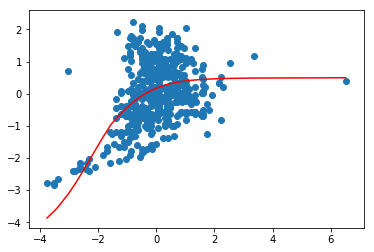

iteration: 600     Estimated Entropy of Residual:  1.1997083940943902


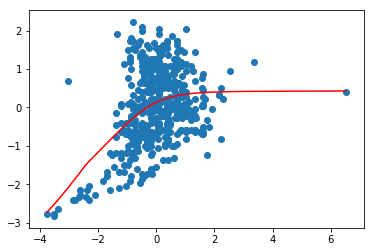

iteration: 650     Estimated Entropy of Residual:  1.2152002413182843


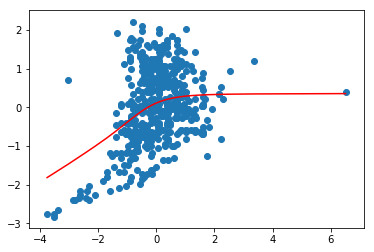

iteration: 700     Estimated Entropy of Residual:  1.186032079749329


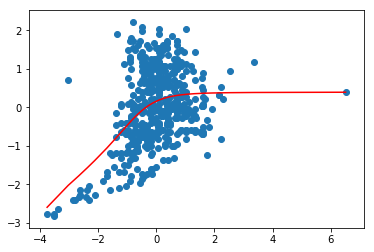

iteration: 750     Estimated Entropy of Residual:  1.2135036943782467


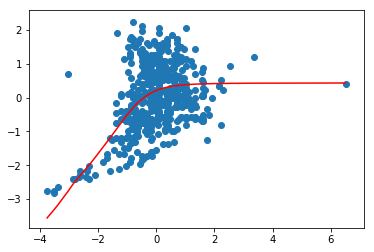

iteration: 800     Estimated Entropy of Residual:  1.2306570158486987


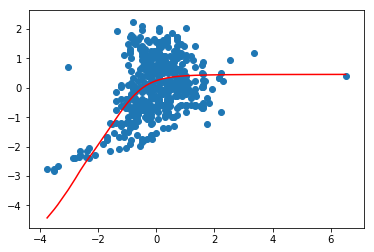

iteration: 850     Estimated Entropy of Residual:  1.2608781601021053


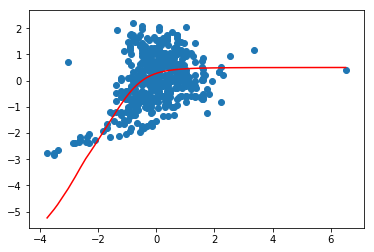

iteration: 900     Estimated Entropy of Residual:  1.2486692206169314


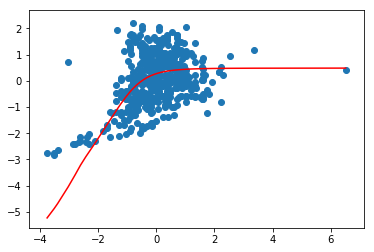

iteration: 950     Estimated Entropy of Residual:  1.2588019640460457


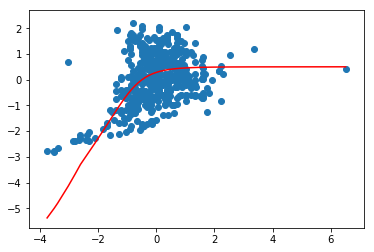

In [33]:
EnsemblePredictsRev = list()
np_loss_allRev = list()
Res_Entr_allRev = list()

# iteration
for iters in range(MaxIters):
    
    # use 'UpdateRegNet' method to update regression network by back-propagattion
    AllPredicts, _, np_lossRev, _, _, Res_Entr = MODEL2.UpdateRegNet(X=Y, Y=X, iteration=iters, 
                                                            RegLearnRate=RLearnRate, nReg_Steps=nReg_Steps)
    np_loss_allRev.append(np_lossRev)
    Res_Entr_allRev.append(Res_Entr)
    
    # use 'UpdateMINet' method to update mutual-information network by back-propagattion
    _ = MODEL2.UpdateMINet(X=Y, Y=X, iteration=iters, 
                           MILearnRate=MILearnRate, nMI_Steps=nMI_Steps)
    
    # use 'TestModel' method to validate the obtained regression-net
    MSE_iter, _ = MODEL2.TestModel(X=Y, Y=X, iteration=iters)
    
    
    # verbose at each 50 iteration
    if iters%50 == 0:
        print('iteration:', iters , '    Estimated Entropy of Residual: ', Res_Entr)
        
        if iters>=200:
            EnsemblePredictsRev.append(AllPredicts-np.mean(AllPredicts))
        
        Imlists = sorted(zip(*[Y, AllPredicts+np.mean(X)-np.mean(AllPredicts)]))
        new_x, new_y = list(zip(*Imlists))
        
        plt.figure()
        plt.plot(new_x, new_y, 'r')
        plt.scatter(Y, X)
        plt.show()
    
# use 'PredictAfterTrain' method to get predictions (outputs of regression)
AllPredictsAfterTrainRev = MODEL2.PredictAfterTrain(X=Y)

# ensemble
EnsemblePredictsWholeRev = np.mean(EnsemblePredictsRev, axis=0)
Imlists = sorted(zip(*[Y, EnsemblePredictsWholeRev+np.mean(X)-np.mean(EnsemblePredictsWholeRev)]))
new_x_ATRev, new_y_ATRev = list(zip(*Imlists))

In [646]:
# use 'EndSession' method to close session after training.
# Note that by closing session, the trained model no longer can be used.
MODEL2.EndSession()

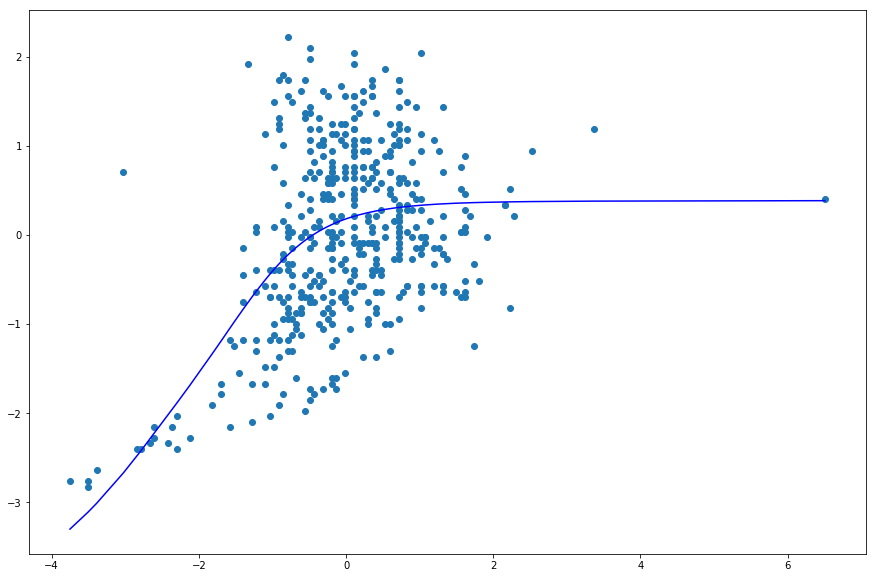

In [35]:
plt.figure(figsize=(15,10))
plt.plot(new_x_ATRev, new_y_ATRev, 'b')
plt.scatter(Y, X)
plt.show()

In [36]:
ImlistsMain = sorted(zip(*[Y, X]))
new_x_Main, new_y_Main = list(zip(*ImlistsMain))
new_y_ATRev = np.asarray(new_y_ATRev)
InData = np.concatenate([new_x_Main, new_y_Main-new_y_ATRev], axis=1)
BackwardError = np.asarray(new_y_Main-new_y_ATRev)
BackwardPredict = np.asarray(new_y_ATRev)

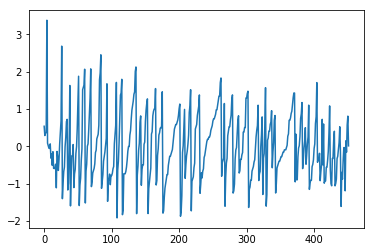

0.8677576319841477


In [37]:
plt.plot(BackwardError)
plt.show()
print(np.std(BackwardError))

In [38]:
tf.reset_default_graph()

InputSize = 2
batch_size = 2*BatchSize//2

layer_ids = ['hidden1','out']#['hidden1','hidden2','hidden3','hidden4','hidden5','out']
layer_sizes = [InputSize, 40, 1]#[InputSize, 5, 10, 10, 5, 2, 1]

# Inputs and Labels
train_inputs = tf.placeholder(tf.float32, shape=[batch_size, layer_sizes[0]], name='train_inputs')


# Learning Rate
tf_learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')


# Weight and Bias definitions
for idx, lid in enumerate(layer_ids):
    #print(idx,'   ',lid)
    with tf.variable_scope(lid):
        w = tf.get_variable('weights',shape=[layer_sizes[idx], layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('bias',shape= [layer_sizes[idx+1]],
                            initializer=tf.contrib.layers.xavier_initializer())

# Calculating Predictions
h = train_inputs
for lid in layer_ids:
    with tf.variable_scope(lid,reuse=True):
        w, b = tf.get_variable('weights'), tf.get_variable('bias')
        #print(w,'\n\n')
        if lid != 'out':
            h = tf.nn.leaky_relu(tf.matmul(h,w)+b,name=lid+'_output')
        else:
            h = tf.nn.xw_plus_b(h,w,b,name=lid+'_output')


# Calculating Loss
tf_loss = tf.negative(Loss_MI(h), name='loss_MINE')

# Optimizer
optimizer = tf.train.AdamOptimizer(tf_learning_rate, beta1=0.96)
grads_and_vars = optimizer.compute_gradients(tf_loss)
tf_loss_minimize = optimizer.minimize(tf_loss)

In [39]:
n_epochs = 5000
LearningRate = 0.00005

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

session = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

avg_lossRev = list()
for epoch in range(n_epochs):
    loss_per_epoch = []
    
    JointBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    MarginalBatchIndeces = batch_index_generator(NumSamples, batch_size//2, 2*NumSamples//batch_size)
    for i in range(2*NumSamples//batch_size):
        
        # =================================== Training for one step ========================================
        batch_joint = InData[JointBatchIndeces[:,i],:]    # Get one batch of joint data
        batch_marginal = InData[MarginalBatchIndeces[:,i],:]    # Get one batch of marginal data
        batch_marginal[:,0:dimX] = batch_joint[:,0:dimX]
        AllBatch = np.concatenate([batch_joint, batch_marginal], axis=0)
        l,_ = session.run([tf_loss, tf_loss_minimize],
                          feed_dict={train_inputs: AllBatch,
                                     tf_learning_rate: LearningRate})
        
        loss_per_epoch.append(l)
    if epoch%50==0:
        print('Average loss in epoch %d: %.5f'%(epoch,-np.mean(loss_per_epoch)))    
    avg_lossRev.append(-np.mean(loss_per_epoch))
    
    

session.close()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Average loss in epoch 0: -0.07909
Average loss in epoch 50: -0.04060
Average loss in epoch 100: -0.02092
Average loss in epoch 150: -0.01802
Average loss in epoch 200: -0.00670
Average loss in epoch 250: 0.00033
Average loss in epoch 300: 0.00035
Average loss in epoch 350: 0.00987
Average loss in epoch 400: -0.00456
Average loss in epoch 450: 0.00354
Average loss in epoch 500: 0.00449
Average loss in epoch 550: 0.00586
Average loss in epoch 600: 0.00647
Average loss in epoch 650: 0.01577
Average loss in epoch 700: 0.00189
Average loss in epoch 750: 0.00869
Average loss in epoch 800: 0.00165
Average loss in epoch 850: 0.01711
Average loss in epoch 900: 0.01162
Average loss in epoch 950: 0.00513
Average loss in epoch 1000: 0.01273
Average loss in epoch 1050: 0.01152
Average loss in epoch 1100: 0.02404
Average loss in epoch 1150: 0.01228
Average loss in epoch 1200: 0.01137
Average loss in epoch 1250: 0.01691
Average loss in epoch 1300: 0.01331
Average loss in epoch 1350: 0.01023
Average l

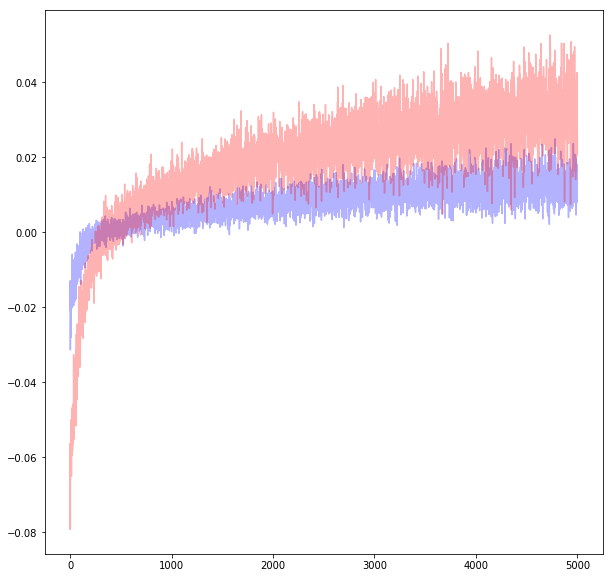

Forward MI: 0.012773045
Backward MI: 0.031927347


In [40]:
plt.figure(figsize=(10,10))
plt.plot(avg_loss, 'b', alpha=0.3)
plt.plot(avg_lossRev, 'r', alpha=0.3)
plt.show()
print('Forward MI:', np.mean(avg_loss[-500:-1]))
print('Backward MI:', np.mean(avg_lossRev[-500:-1]))